<a href="https://colab.research.google.com/github/VijayRameshkumar/CVAssignmentDataset/blob/main/CV_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np

import nltk
nltk.download('vader_lexicon')

from nltk.sentiment.vader import SentimentIntensityAnalyzer

import tensorflow as tf
from sklearn.metrics import confusion_matrix, f1_score, matthews_corrcoef
import re

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


/usr/local/lib/python3.6/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [2]:
!git clone https://github.com/eshwarprasadS/CVAssignmentDataset.git

Cloning into 'CVAssignmentDataset'...
remote: Enumerating objects: 11, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 11 (delta 2), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (11/11), done.


In [3]:
%cd CVAssignmentDataset

/content/CVAssignmentDataset


In [4]:
df = pd.read_csv("/content/CVAssignmentDataset/CVAssignmentDataset.csv")
df = df.drop_duplicates(ignore_index=True)
print("List of Features : {}".format(list(df.columns)))

List of Features : ['Class', 'Text']


In [5]:
df.head()

,Class,Text
0,1,"Today, Senate Dems vote to #SaveTheInternet. P..."
1,1,RT @WinterHavenSun: Winter Haven resident / Al...
2,1,RT @NBCLatino: .@RepDarrenSoto noted that Hurr...
3,1,RT @NALCABPolicy: Meeting with @RepDarrenSoto ...
4,1,RT @Vegalteno: Hurricane season starts on June...


### Class Description

In [6]:
df.describe()

,Class,Text
count,84550,84549
unique,3,84502
top,0,RT @NLintheUSA: Members of the Dutch and EU Ca...
freq,43435,2


In [7]:
df.Class.value_counts()

0                          43435
1                          41114
https://t.co/sbSljdw1Zw        1
Name: Class, dtype: int64

In [8]:
df.drop(index=[list(df.Class.loc[df.Class == 'https://t.co/sbSljdw1Zw'].index)[0]], inplace=True)

In [9]:
from nltk import word_tokenize
from nltk.corpus import stopwords
nltk.download('stopwords')

stop = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [10]:
import tqdm

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

from tqdm import tqdm

def preprocess_text(text_data):
    preprocessed_text = []
    urls = []
    # tqdm is for printing the status bar

    for sentance in tqdm(text_data):
        sent = decontracted(sentance)
        url = re.findall(r'(https?://\S+)', sent)
        urls.append(url)

        sent = re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', ' ', sent)
        sent = sent.replace('\\r', ' ')
        sent = sent.replace('\\n', ' ')
        sent = sent.replace('\\"', ' ')
        sent = re.sub('[^A-Za-z0-9]+', ' ', sent)

        sent = ' '.join(e for e in sent.split() if e.lower() not in stop)
        preprocessed_text.append(sent.lower().strip())
        
    return preprocessed_text, urls

text, urls = preprocess_text(df['Text'].values)

100%|██████████| 84549/84549 [00:02<00:00, 28719.87it/s]


In [11]:
y = df['Class'].values

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

xtrain, xtest, ytrain, ytest = train_test_split(np.asarray(text), y, test_size=0.30, stratify=y, random_state=123)

print(xtrain.shape, xtest.shape, ytrain.shape, ytest.shape)
ytrain = ytrain.astype('int8')
ytest = ytest.astype('int8')

(59184,) (25365,) (59184,) (25365,)


## CountVectorizer

In [13]:
def getFitCountVectorizer(preprocessed_data):
    vectorizer = CountVectorizer(ngram_range=(2,2), max_features=10000, min_df=10)
    vectorizer.fit(preprocessed_data)
    return vectorizer

def getCountVectorizeTxtData(preprocessed_data, vectorizer):
    text_tfidf = vectorizer.transform(preprocessed_data)
    print("Shape of matrix after count_vect encodig ",text_tfidf.shape)
    return text_tfidf

## TFIDF

In [14]:
def getFitTFIDF_Vectorizer(preprocessed_data):
    vectorizer = TfidfVectorizer(ngram_range=(2,2), max_features=10000, min_df=10)
    vectorizer.fit(preprocessed_data)
    return vectorizer

def getTFIDFVectorizeTxtData(preprocessed_data, vectorizer):
    text_tfidf = vectorizer.transform(preprocessed_data)
    print("Shape of matrix after tfidf encodig ",text_tfidf.shape)
    return text_tfidf

## TFIDF_W2V

In [28]:
import pickle
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import gensim

w2v_path = '/content/drive/MyDrive/6_Donors_choose_NB/glove_vectors'

with open(w2v_path, 'rb') as f:
    model = pickle.load(f)
    glove_words = set(model.keys())

def TFIDF_W2V(preprocessed_data):
    tfidf_model = TfidfVectorizer(ngram_range=(2,2), max_features=10000, min_df=10)
    tfidf_model.fit(text)
    return tfidf_model

def getTFIDF_W2V(preprocessed_data, tfidf_model):
    # we are converting a dictionary with word as a key, and the idf as a value
    dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
    tfidf_words = set(tfidf_model.get_feature_names())
    tfidf_w2v_vectors = []; # the avg-w2v for each sentence/review is stored in this list

    for sentence in tqdm(preprocessed_data): # for each review/sentence
        vector = np.zeros(50) # as word vectors are of zero length
        tf_idf_weight =0; # num of words with a valid vector in the sentence/review

        for word in sentence.split(): # for each word in a review/sentence
            if (word in glove_words) and (word in tfidf_words):
                vec = model[word] # getting the vector for each word
                tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) 
                vector += (vec * tf_idf) # calculating tfidf weighted w2v
                tf_idf_weight += tf_idf
        if tf_idf_weight != 0:
            vector /= tf_idf_weight
        tfidf_w2v_vectors.append(vector)

    print(len(tfidf_w2v_vectors))
    print(len(tfidf_w2v_vectors[0]))
    return np.asarray(tfidf_w2v_vectors)

## Sentiment_Analyser

In [16]:
def sentiment_anayser(essay):
    sid = SentimentIntensityAnalyzer()
    
    negative = []
    positive = []
    neutral = []
    compound = []

    for sentence in essay:
        ss = sid.polarity_scores(sentence)
        sentmnt = list(ss.values())
        neg = sentmnt[0]
        neu = sentmnt[1]
        pos = sentmnt[2]
        cmpd = sentmnt[3]

        negative.append(neg)
        neutral.append(neu)
        positive.append(pos)
        compound.append(cmpd)
    return np.column_stack((np.array(negative), np.array(neutral), 
                            np.array(positive), np.array(compound)))

# Neural Network (BI_LSTM)

In [17]:
import csv
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from tensorflow.keras.layers import Dense, Flatten, LSTM, Dropout, Activation, Embedding, Bidirectional, TimeDistributed
from tensorflow.keras import Input, Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.metrics import AUC

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

In [18]:
xtrain, xtest, ytrain, ytest = train_test_split(df['Text'], y, test_size=0.20, stratify=y, random_state=123)

ytrain, ytest = ytrain.astype('int64'), ytest.astype('int64')

vocab_size = 10000 # make the top list of words (common words)
embedding_dim = 32
max_length = 50
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>' # OOV = Out of Vocabulary
training_portion = .8

tokenizer = Tokenizer(num_words=10000, lower=True,split=' ')
tokenizer.fit_on_texts(xtrain)

train_sequences = tokenizer.texts_to_sequences(xtrain)
train_padded = pad_sequences(train_sequences, maxlen=max_length)
validation_sequences = tokenizer.texts_to_sequences(xtest)
validation_padded = pad_sequences(validation_sequences, maxlen=max_length)

def MODEL():
    # Input for variable-length sequences of integers
    inputs = Input(shape=(50,), dtype="int32")
    # Embed each integer in a 128-dimensional vector
    x = Embedding(vocab_size, 32)(inputs)
    x = Conv1D(filters=32, kernel_size=3, padding='same', activation='relu')(x)
    x = MaxPooling1D(pool_size=2)(x)
    # Add 2 bidirectional LSTMs
    x = Bidirectional(LSTM(256, return_sequences=True))(x)
    x = Dropout(0.5)(x)
    x = Bidirectional(LSTM(256))(x)
    x = Dropout(0.5)(x)
    # Add a classifier
    x = Dense(1024, activation="relu")(x)
    x = Dropout(0.5)(x)
    x = Dense(512, activation="relu")(x)
    x = Dropout(0.5)(x)
    outputs = x = Dense(1, activation="sigmoid")(x)
    model = Model(inputs, outputs)
    return model

model = MODEL()
model.compile(loss='binary_crossentropy',optimizer='adam',  metrics=['accuracy'])
model.summary()
checkpoint = ModelCheckpoint('best_model.h5', verbose=1, monitor='val_accuracy', save_best_only=True, mode='auto')

history = model.fit(train_padded, ytrain, validation_split=0.4, epochs=10, batch_size=32, callbacks=[checkpoint], verbose=True, shuffle = True)


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 50)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 50, 32)            320000    
_________________________________________________________________
conv1d (Conv1D)              (None, 50, 32)            3104      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 25, 32)            0         
_________________________________________________________________
bidirectional (Bidirectional (None, 25, 512)           591872    
_________________________________________________________________
dropout (Dropout)            (None, 25, 512)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 512)               157491

In [19]:
from keras.models import load_model

model = load_model('/content/CVAssignmentDataset/best_model.h5')

scores = model.evaluate(validation_padded, ytest, verbose=0)

print("TEST - Accuracy: %.2f%%" % (scores[1]*100))

scores = model.evaluate(train_padded, ytrain, verbose=0)

print("TRAIN - Accuracy: %.2f%%" % (scores[1]*100))

TEST - Accuracy: 77.27%
TRAIN - Accuracy: 84.55%


In [20]:
history.history.keys()
history = history.history

# Plots

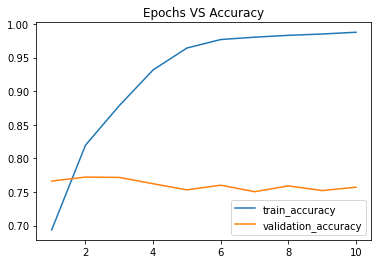

In [21]:
import matplotlib.pyplot as plt
epochs = np.arange(1, 11, 1)

plt.plot(epochs, history['accuracy'], label='train_accuracy')
plt.plot(epochs, history['val_accuracy'], label='validation_accuracy')
plt.title("Epochs VS Accuracy")
plt.legend()
plt.show()

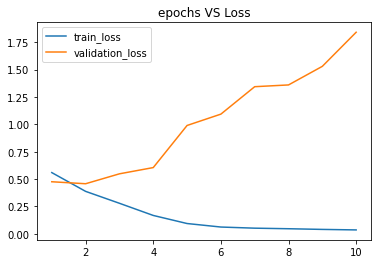

In [22]:
plt.plot(epochs, history['loss'], label='train_loss')
plt.plot(epochs, history['val_loss'], label='validation_loss')
plt.title("epochs VS Loss")
plt.legend()
plt.show()

# Confusion Matrix


 ################################################## 

##########    TRAIN_CONFUSION_MATRIX    ########## 

################################################## 



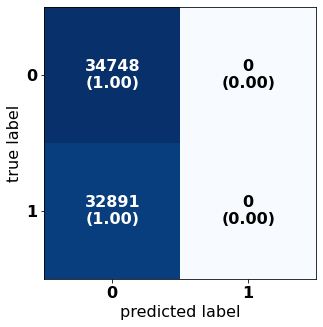

In [23]:
from sklearn.metrics import confusion_matrix, matthews_corrcoef

train_predict = model.predict(train_padded)
train_predict = np.argmax(train_predict, axis = 1).ravel()
test_predict = model.predict(validation_padded)
test_predict = np.argmax(test_predict, axis = 1).ravel()

train_confusion = confusion_matrix(ytrain, train_predict)
test_confusion = confusion_matrix(ytest, test_predict)

from mlxtend.plotting import plot_confusion_matrix

font = {
'family' : 'DejaVu Sans',
'weight' : 'bold',
'size' : '16'
}
plt.rc('font', **font)

print("\n", "#" * 50, "\n")
print("#" * 10, "  ", "TRAIN_CONFUSION_MATRIX", "  ", "#"*10, "\n")
print("#" * 50, "\n")

plot_confusion_matrix(conf_mat=train_confusion, figsize=(5,5), show_normed=True);


 ################################################## 

##########    TEST_CONFUSION_MATRIX    ########## 

################################################## 



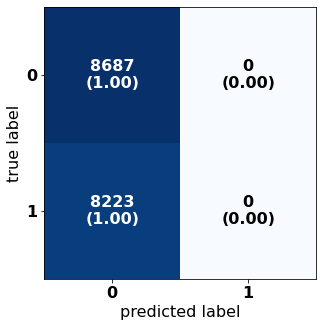

In [24]:
print("\n", "#" * 50, "\n")
print("#" * 10, "  ", "TEST_CONFUSION_MATRIX", "  ", "#"*10, "\n")
print("#" * 50, "\n")

plot_confusion_matrix(conf_mat=test_confusion, figsize=(5,5), show_normed=True);

# Matthews_corrcoef

In [25]:
train_matthews_corrcoef = matthews_corrcoef(ytrain, train_predict)
test_matthews_corrcoef = matthews_corrcoef(ytest, test_predict)

print("Train_matthews_corrcoef : " , train_matthews_corrcoef)
print("Test_matthews_corrcoef : ", test_matthews_corrcoef)

Train_matthews_corrcoef :  0.0
Test_matthews_corrcoef :  0.0


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


In [26]:
y = y.astype('int8')

xtrain, xtest, ytrain, ytest = train_test_split(text, y, test_size=0.3, stratify=y)

# Various Featurisation Methods with NeuralNetwork

In [30]:
sets = ['tfidf', 'w2v', 'count']
scorer = dict()

for set_ in sets:
    if set_ == 'tfidf':
        vectorizer = getFitTFIDF_Vectorizer(xtrain)
        temp_1 = getTFIDFVectorizeTxtData(xtrain, vectorizer).toarray()
        temp_2 = getTFIDFVectorizeTxtData(xtest, vectorizer).toarray()
        temp_1 = pad_sequences(temp_1, maxlen=50)
        temp_2 = pad_sequences(temp_2, maxlen=50)
        # temp_1 = np.column_stack((sentiment_anayser(xtrain), temp_1))
        # temp_2 = np.column_stack((sentiment_anayser(xtest), temp_2))
        print(set_ , ": ", temp_1.shape, temp_2.shape)

    elif set_ == 'w2v':
        vectorizer = TFIDF_W2V(xtrain)
        temp_1 = getTFIDF_W2V(xtrain, vectorizer)
        temp_2 = getTFIDF_W2V(xtest, vectorizer)
        # temp_1 = np.column_stack((sentiment_anayser(xtrain), temp_1))
        # temp_2 = np.column_stack((sentiment_anayser(xtest), temp_2))
        print(set_ , ": ", temp_1.shape, temp_2.shape)        

    elif set_ == 'count':
        vectorizer = getFitCountVectorizer(xtrain)
        temp_1 = getCountVectorizeTxtData(xtrain, vectorizer).toarray()
        temp_2 = getCountVectorizeTxtData(xtest, vectorizer).toarray()
        temp_1 = pad_sequences(temp_1, maxlen=50)
        temp_2 = pad_sequences(temp_2, maxlen=50)
        # temp_1 = np.column_stack((sentiment_anayser(xtrain), temp_1))
        # temp_2 = np.column_stack((sentiment_anayser(xtest), temp_2))
        print(set_ , ": ", temp_1.shape, temp_2.shape)

    
    model = MODEL()
    model.compile(loss='binary_crossentropy',optimizer='adam',  metrics=['accuracy'])
    # model.summary()
    checkpoint = ModelCheckpoint('best_model_{}.h5'.format(set_), verbose=1, monitor='val_accuracy', save_best_only=True, mode='auto')

    history = model.fit(temp_1, ytrain, validation_split=0.4, epochs=5, batch_size=64, callbacks=[checkpoint], verbose=True, shuffle = True)

Shape of matrix after tfidf encodig  (59184, 3910)
Shape of matrix after tfidf encodig  (25365, 3910)
tfidf :  (59184, 50) (25365, 50)
Epoch 1/5
555/555 [==============================] - 18s 24ms/step - loss: 0.6941 - accuracy: 0.5051 - val_loss: 0.6929 - val_accuracy: 0.5139

Epoch 00001: val_accuracy improved from -inf to 0.51385, saving model to best_model_tfidf.h5
Epoch 2/5
555/555 [==============================] - 12s 22ms/step - loss: 0.6935 - accuracy: 0.5024 - val_loss: 0.6935 - val_accuracy: 0.5139

Epoch 00002: val_accuracy did not improve from 0.51385
Epoch 3/5
555/555 [==============================] - 12s 22ms/step - loss: 0.6925 - accuracy: 0.5140 - val_loss: 0.6928 - val_accuracy: 0.5139

Epoch 00003: val_accuracy did not improve from 0.51385
Epoch 4/5
555/555 [==============================] - 12s 22ms/step - loss: 0.6931 - accuracy: 0.5100 - val_loss: 0.6928 - val_accuracy: 0.5139

Epoch 00004: val_accuracy did not improve from 0.51385
Epoch 5/5
555/555 [============

100%|██████████| 25365/25365 [00:00<00:00, 249700.80it/s]


59184
50
25365
50
w2v :  (59184, 50) (25365, 50)
Epoch 1/5
555/555 [==============================] - 20s 28ms/step - loss: 0.6942 - accuracy: 0.5038 - val_loss: 0.6933 - val_accuracy: 0.4861

Epoch 00001: val_accuracy improved from -inf to 0.48615, saving model to best_model_w2v.h5
Epoch 2/5
555/555 [==============================] - 12s 22ms/step - loss: 0.6935 - accuracy: 0.5055 - val_loss: 0.6929 - val_accuracy: 0.5139

Epoch 00002: val_accuracy improved from 0.48615 to 0.51385, saving model to best_model_w2v.h5
Epoch 3/5
555/555 [==============================] - 12s 22ms/step - loss: 0.6930 - accuracy: 0.5152 - val_loss: 0.6928 - val_accuracy: 0.5139

Epoch 00003: val_accuracy did not improve from 0.51385
Epoch 4/5
555/555 [==============================] - 12s 22ms/step - loss: 0.6932 - accuracy: 0.5152 - val_loss: 0.6928 - val_accuracy: 0.5139

Epoch 00004: val_accuracy did not improve from 0.51385
Epoch 5/5
555/555 [==============================] - 13s 23ms/step - loss: 0.693

# Various Featurisation Methods with Classical ML Algos

In [45]:
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

sets = ['tfidf', 'w2v', 'count']
scorer = dict()

for set_ in sets:
    if set_ == 'tfidf':
        vectorizer = getFitTFIDF_Vectorizer(xtrain)
        temp_1 = getTFIDFVectorizeTxtData(xtrain, vectorizer).toarray()
        temp_2 = getTFIDFVectorizeTxtData(xtest, vectorizer).toarray()
        temp_1 = pad_sequences(temp_1, maxlen=50)
        temp_2 = pad_sequences(temp_2, maxlen=50)
        # temp_1 = np.column_stack((sentiment_anayser(xtrain), temp_1))
        # temp_2 = np.column_stack((sentiment_anayser(xtest), temp_2))
        print(set_ , ": ", temp_1.shape, temp_2.shape)

    elif set_ == 'w2v':
        vectorizer = TFIDF_W2V(xtrain)
        temp_1 = getTFIDF_W2V(xtrain, vectorizer)
        temp_2 = getTFIDF_W2V(xtest, vectorizer)
        # temp_1 = np.column_stack((sentiment_anayser(xtrain), temp_1))
        # temp_2 = np.column_stack((sentiment_anayser(xtest), temp_2))
        print(set_ , ": ", temp_1.shape, temp_2.shape)        

    elif set_ == 'count':
        vectorizer = getFitCountVectorizer(xtrain)
        temp_1 = getCountVectorizeTxtData(xtrain, vectorizer).toarray()
        temp_2 = getCountVectorizeTxtData(xtest, vectorizer).toarray()
        temp_1 = pad_sequences(temp_1, maxlen=50)
        temp_2 = pad_sequences(temp_2, maxlen=50)
        # temp_1 = np.column_stack((sentiment_anayser(xtrain), temp_1))
        # temp_2 = np.column_stack((sentiment_anayser(xtest), temp_2))
        print(set_ , ": ", temp_1.shape, temp_2.shape)

    gnb = GaussianNB()
    sv = SVC()

    print("\n", set_ , " :\n")
    y_pred = gnb.fit(temp_1, ytrain).predict(temp_2)
    print("GNB : ", accuracy_score(ytest, y_pred))

    y_pred = sv.fit(temp_1, ytrain).predict(temp_2)
    print("SVC : ", accuracy_score(ytest, y_pred))


Shape of matrix after tfidf encodig  (59184, 3910)
Shape of matrix after tfidf encodig  (25365, 3910)
tfidf :  (59184, 50) (25365, 50)

 tfidf  :

GNB :  0.5149221368026808


/usr/local/lib/python3.6/dist-packages/sklearn/naive_bayes.py:206: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVC :  0.5149221368026808


100%|██████████| 25365/25365 [00:00<00:00, 258913.96it/s]
/usr/local/lib/python3.6/dist-packages/sklearn/naive_bayes.py:206: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


59184
50
25365
50
w2v :  (59184, 50) (25365, 50)

 w2v  :



/usr/local/lib/python3.6/dist-packages/sklearn/naive_bayes.py:450: RuntimeWarning: divide by zero encountered in log
  n_ij = - 0.5 * np.sum(np.log(2. * np.pi * self.sigma_[i, :]))
/usr/local/lib/python3.6/dist-packages/sklearn/naive_bayes.py:452: RuntimeWarning: invalid value encountered in true_divide
  (self.sigma_[i, :]), 1)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GNB :  0.513739404691504
SVC :  0.513739404691504
Shape of matrix after count_vect encodig  (59184, 3910)
Shape of matrix after count_vect encodig  (25365, 3910)
count :  (59184, 50) (25365, 50)

 count  :

GNB :  0.4883895131086142


/usr/local/lib/python3.6/dist-packages/sklearn/naive_bayes.py:206: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVC :  0.519692489651094


# Results : 

In [46]:
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["Vectorizer", "Model", "Train_Accuracy", "Valid_AUC"]

x.add_row(["Keras - tokenise & WordEmbedding",'NeuralNet (BI_LSTM)', 0.85, '0.74'])

x.add_row(["TFIDF-W2V",'NeuralNet (BI_LSTM)', 0.51, '0.51'])
x.add_row(["TFIDF", 'NeuralNet (BI_LSTM)', 0.50, '0.51'])
x.add_row(["BOW", 'NeuralNet (BI_LSTM)', 0.52, '0.51'])

x.add_row(["TFIDF-W2V",'SVC', 0.51, '-'])
x.add_row(["TFIDF", 'SVC', 0.51, '-'])
x.add_row(["BOW", 'SVC', 0.48, '-'])

x.add_row(["TFIDF-W2V",'GNB', 0.51, '-'])
x.add_row(["TFIDF", 'GNB', 0.51, '-'])
x.add_row(["BOW", 'GNB', 0.51, '-'])

print(x)

+----------------------------------+---------------------+----------------+-----------+
|            Vectorizer            |        Model        | Train_Accuracy | Valid_AUC |
+----------------------------------+---------------------+----------------+-----------+
| Keras - tokenise & WordEmbedding | NeuralNet (BI_LSTM) |      0.85      |    0.74   |
|            TFIDF-W2V             | NeuralNet (BI_LSTM) |      0.51      |    0.51   |
|              TFIDF               | NeuralNet (BI_LSTM) |      0.5       |    0.51   |
|               BOW                | NeuralNet (BI_LSTM) |      0.52      |    0.51   |
|            TFIDF-W2V             |         SVC         |      0.51      |     -     |
|              TFIDF               |         SVC         |      0.51      |     -     |
|               BOW                |         SVC         |      0.48      |     -     |
|            TFIDF-W2V             |         GNB         |      0.51      |     -     |
|              TFIDF            